In [1]:
import re

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read and clean data

In [4]:
data = pd.read_csv('model_data_5_2.csv')

In [5]:
keep = ['Plc.','Jockey','Trainer',\
        'Actual Wt.','Declar. Horse Wt.','Draw',\
        'oriental_1','oriental_2','oriental_3',\
        'apple_1','apple_2','apple_3',\
        'pro_1','pro_2','pro_3',\
        'w_h_odd','s_b_odd',\
        'race_id','Class','Length','Going','Course']

In [6]:
# column to keep for modeling
model_data = data[keep]

In [7]:
# percentage of na rows
(model_data.isna().sum(1) > 0).sum() / model_data.shape[0]

0.02324561403508772

In [8]:
yo = model_data[model_data.isna().sum(1) > 0]
wow = model_data[model_data.isna().sum(1) == 0]

In [9]:
# all na rows has no Plc, so no result
yo['Plc.'].unique()

array(['WV', 'WX', nan, 'WX-A', 'WV-A', 'WXNR'], dtype=object)

In [10]:
# drop all NA, since they anyway have no result
model_data_rna = model_data.dropna().reset_index(drop=True)

In [11]:
model_data_rna['Plc.'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '3 DH', '5 DH', '2 DH', '8 DH', '9 DH', 'UR', '7 DH',
       'FE', 'TNP', 'DNF', 'PU', '10 DH', '12 DH', '1 DH', '11 DH',
       '4 DH', '6 DH'], dtype=object)

In [12]:
# rm rows with no result
model_data_rna = model_data_rna[~model_data_rna['Plc.'].isin(['FE','TNP','DNF','PU','UR'])].reset_index(drop=True)

In [13]:
# handle result
model_data_rna['Plc.'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '3 DH', '5 DH', '2 DH', '8 DH', '9 DH', '7 DH',
       '10 DH', '12 DH', '1 DH', '11 DH', '4 DH', '6 DH'], dtype=object)

In [14]:
model_data_rna['Plc.'] = [int(re.sub(r'\s[a-zA-Z]{1,3}$', '', i)) for i in model_data_rna['Plc.']]

## Cat and Cont variables

In [15]:
# categorical data
cat_data = model_data_rna.select_dtypes('object')
cat_data = cat_data[[i for i in list(cat_data) if i not in ['Plc.','race_id']]]

# continuous data
cont_data = model_data_rna.select_dtypes(['float','int'])
cont_data = cont_data[[i for i in list(cont_data) if i != 'Plc.']]

# race id and result
id_ = model_data_rna[['race_id']]
result = model_data_rna['Plc.'].values

# postition result
position = (result <= 3).astype('int')

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Feature importance

## Continuous variables

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
X = StandardScaler().fit_transform(cont_data)

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
clf = LogisticRegression(random_state=0, penalty='l1', C=0.01, solver='liblinear').fit(X, position)

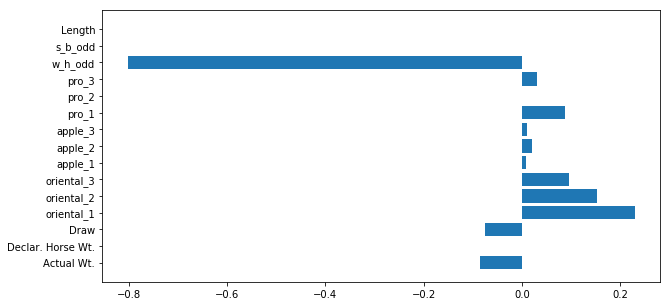

In [21]:
plt.figure(figsize=(10,5))
plt.barh(list(cont_data), clf.coef_[0])
plt.show()

In [22]:
pd.DataFrame({'variable':list(cont_data), 'coef':clf.coef_[0]})

,variable,coef
0,Actual Wt.,-0.084569
1,Declar. Horse Wt.,0.000000
2,Draw,-0.075111
3,oriental_1,0.230401
4,oriental_2,0.153004
5,oriental_3,0.095846
6,apple_1,0.007623
7,apple_2,0.020765
8,apple_3,0.009928
9,pro_1,0.088069


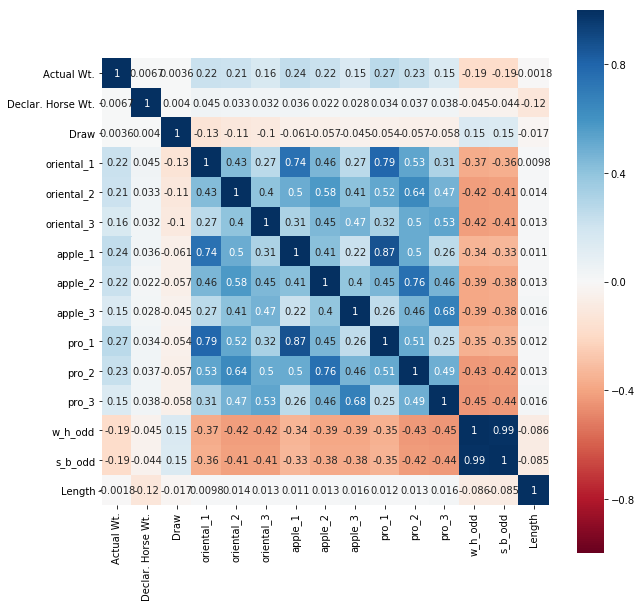

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(cont_data.corr(), cmap='RdBu', square=True, annot=True, vmin=-1, vmax=1)
plt.show()

In [24]:
cont_keep = [list(cont_data)[i] for i in np.where(clf.coef_[0] != 0)[0]]

## Categorical variables

In [25]:
from sklearn.feature_selection import chi2

In [26]:
def map_cat_to_num(in_arr):
    unique = np.unique(in_arr)
    mapper = {j:i for i,j in enumerate(unique)}
    return np.array([mapper[i] for i in in_arr])

In [27]:
cat_data.head()

,Jockey,Trainer,Class,Going,Course
0,Z Purton,K L Man,Class 4,GOOD,"TURF - ""C"" Course"
1,J Moreira,J Size,Class 4,GOOD,"TURF - ""C"" Course"
2,O Chavez,A S Cruz,Class 4,GOOD,"TURF - ""C"" Course"
3,U Rispoli,T P Yung,Class 4,GOOD,"TURF - ""C"" Course"
4,K Teetan,D E Ferraris,Class 4,GOOD,"TURF - ""C"" Course"


$p<\alpha$, reject null hypothesis, X and y are associated

In [28]:
cat_keep = list()
for i in list(cat_data):
    bow = map_cat_to_num(cat_data[i]).reshape(-1,1)
    p_value = chi2(bow, position)[1]
    if p_value < 0.05:
        asso = 'associate'
        cat_keep.append(i)
    else:
        asso = 'not associate'
    print(i, round(p_value[0], 20), asso)

Jockey 0.0 associate
Trainer 0.0 associate
Class 0.04208589937934474 associate
Going 0.4764875168999265 not associate
Course 0.6728480850787857 not associate


# Trainer & Jockey

In [29]:
model_data_rna[cat_keep].describe()

,Jockey,Trainer,Class
count,20021,20021,20021
unique,78,71,12
top,Z Purton,A S Cruz,Class 4
freq,1397,1151,7890


In [73]:
jockey_df = model_data_rna[['Jockey','Plc.']].groupby(
    by='Jockey').agg(['mean','std','count'])['Plc.'].sort_values('mean').rename_axis(None)

In [74]:
trainer_df = model_data_rna[['Trainer','Plc.']].groupby(
    by='Trainer').agg(['mean','std','count'])['Plc.'].sort_values('mean').rename_axis(None)

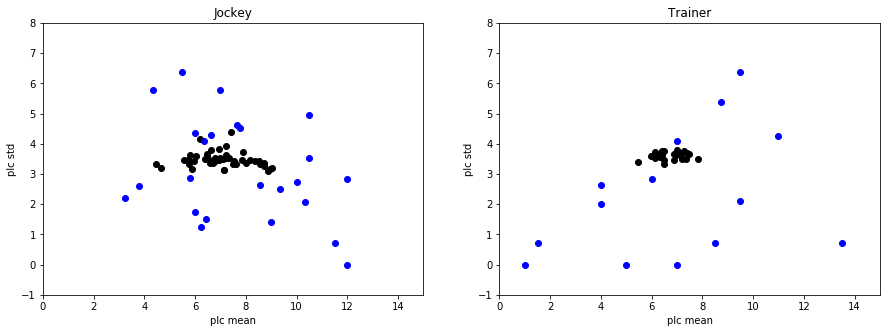

In [86]:
plt.figure(figsize=(15,5))

plt.subplot(121)
for i,j in jockey_df.dropna().iterrows():
    if j['count'] >=10:
        plt.scatter(j['mean'], j['std'], color='black')
    else:
        plt.scatter(j['mean'], j['std'], color='blue')
plt.xlabel('plc mean')
plt.ylabel('plc std')
plt.xlim(0,15)
plt.ylim(-1,8)
plt.title('Jockey')

plt.subplot(122)
for i,j in trainer_df.dropna().iterrows():
    if j['count'] >= 10:
        plt.scatter(j['mean'], j['std'], color='black')
    else:
        plt.scatter(j['mean'], j['std'], color='blue')
plt.xlabel('plc mean')
plt.ylabel('plc std')
plt.xlim(0,15)
plt.ylim(-1,8)
plt.title('Trainer')

plt.show()

## Jockey & Trainer Profile

In [112]:
jockey_dict = jockey_df.to_dict(orient='index')

In [113]:
trainer_dict = trainer_df.to_dict(orient='index')

In [156]:
mapped_jockey = [(jockey_dict[i]['mean'], jockey_dict[i]['std'], jockey_dict[i]['count']) for i in model_data_rna['Jockey']]
mapped_jockey_df = pd.DataFrame(mapped_jockey, columns=['jockey_mean','jockey_std','jockey_count'])
mapped_jockey_df = mapped_jockey_df.fillna(10)

In [157]:
mapped_trainer = [(trainer_dict[i]['mean'], trainer_dict[i]['std'], trainer_dict[i]['count']) for i in model_data_rna['Trainer']]
mapped_trainer_df = pd.DataFrame(mapped_trainer, columns=['trainer_mean','trainer_std','trainer_count'])
mapped_trainer_df = mapped_trainer_df.fillna(10)

# Experiment Data 1
Map jockey and trainer to mean, std, count number and exclude cont features from Lasso

In [178]:
exp1_X = pd.concat([model_data_rna[cont_keep], mapped_jockey_df, mapped_trainer_df], 1)
# position is the response variable

In [177]:
from sklearn.model_selection import train_test_split

In [181]:
np.unique(position, return_counts=True)

(array([0, 1]), array([15056,  4965]))

Downsample balance

In [223]:
zero_idx = np.random.choice(np.where(position == 0)[0], 7000, replace=False)

In [224]:
exp1_X_b = pd.concat([exp1_X.iloc[zero_idx], exp1_X[position == 1]])
exp1_y_b = np.concatenate([position[zero_idx], position[position == 1]])

In [225]:
exp1_X_train, exp1_X_test, exp1_y_train, exp1_y_test = train_test_split(exp1_X_b, exp1_y_b, test_size=0.2)

Scale

In [226]:
exp1_scale = StandardScaler().fit(exp1_X_train)

In [227]:
exp1_X_train_n = exp1_scale.transform(exp1_X_train)
exp1_X_test_n = exp1_scale.transform(exp1_X_test)

Fit

In [228]:
from sklearn.ensemble import RandomForestClassifier

In [229]:
rf = RandomForestClassifier(n_estimators=1800, 
                            min_samples_split=10,
                            min_samples_leaf=2,
                            max_features='auto',
                            max_depth=110,
                            bootstrap=False)

In [230]:
rf.fit(exp1_X_train, exp1_y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [232]:
logit = LogisticRegression(random_state=0, \
                           penalty='l1', \
                           C=1, \
                           solver='liblinear').fit(exp1_X_train_n, exp1_y_train)

In [233]:
logit.score(exp1_X_test_n, exp1_y_test)

0.7003760969494358

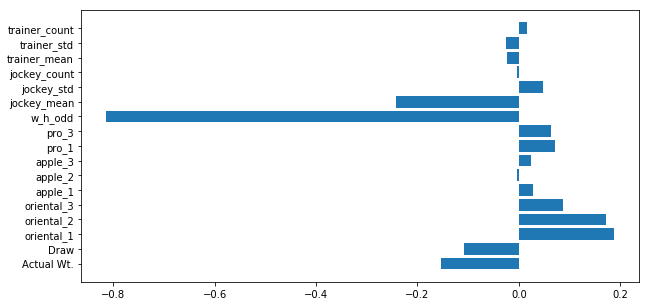

In [235]:
plt.figure(figsize=(10,5))
plt.barh(list(exp1_X), logit.coef_[0])
plt.show()

NN

In [236]:
exp1_X_val_n, exp1_X_test_n, exp1_y_val, exp1_y_test = train_test_split(exp1_X_test_n, exp_y_test, test_size=0.2)

In [246]:
from keras import models
from keras import layers

In [252]:
dnn = models.Sequential()
dnn.add(layers.Dense(64, activation='relu', input_shape=(17,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(1, activation='sigmoid'))

In [253]:
dnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [254]:
history = dnn.fit(exp1_X_train_n, exp1_y_train, 
                  epochs=50, 
                  batch_size=128, 
                  verbose=1,
                  validation_data=[exp1_X_val_n, exp1_y_val])

Train on 9572 samples, validate on 1914 samples
Epoch 1/50
9572/9572 [==============================] - 1s 104us/step - loss: 0.6265 - acc: 0.6463 - val_loss: 0.7529 - val_acc: 0.5204
Epoch 2/50
9572/9572 [==============================] - 0s 22us/step - loss: 0.5914 - acc: 0.6888 - val_loss: 0.7704 - val_acc: 0.5209
Epoch 3/50
9572/9572 [==============================] - 0s 22us/step - loss: 0.5890 - acc: 0.6909 - val_loss: 0.7404 - val_acc: 0.5183
Epoch 4/50
9572/9572 [==============================] - 0s 22us/step - loss: 0.5856 - acc: 0.6948 - val_loss: 0.7701 - val_acc: 0.5172
Epoch 5/50
9572/9572 [==============================] - 0s 21us/step - loss: 0.5815 - acc: 0.6980 - val_loss: 0.7468 - val_acc: 0.5188
Epoch 6/50
9572/9572 [==============================] - 0s 21us/step - loss: 0.5796 - acc: 0.6965 - val_loss: 0.7642 - val_acc: 0.5162
Epoch 7/50
9572/9572 [==============================] - 0s 21us/step - loss: 0.5772 - acc: 0.6961 - val_loss: 0.7379 - val_acc: 0.5178
Epoch 

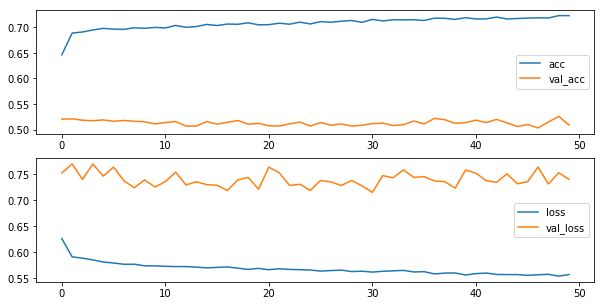

In [255]:
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()